# 네이버 블로그로 파급력을 측정합니다.

In [1]:
import urllib.request
import json
import pandas as pd
import re
# 글에서 해당 키워드 찾기
from konlpy.tag import Kkma
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 트리맵
import squarify

<naverapi 응답 구조>  
lastBuildDate : api 요청한 시각  
total : 관련 블로그 수  
start : 시작  
display : 가져온 갯수  
items : 블로그  
<items 구조>  
title : 블로그 제목    
link : 블로그 링크  
description : 블로그 내용  
bloggername : 블로그 이름  
bloggerlink : 블로그 메인화면  
postdate : 게시날짜  

# 파급력
네이버 데이터 : 음식점과 관련성이 높은 블로그글 순으로 200개의 데이터를 가져옵니다.  
기준일 : 네이버 데이터 중 제공기관 키워드가 블로그 제목이나 간략한 설명에 들어간 글 중 가장 오래전에 포스트된 날짜  
        (관련된 글이 없다면 기준일은 "2099-12-31 00:00:00"이 됩니다.)  
        
## 가게에 대한 신뢰도 : 미디어가 해당 음식점의 영향력에 얼마나 주었나
power3 : 해당 미디어의 영향력  
reliability2 : 영향력이 얼마나 큰가
## 파급력의 신뢰도 : 미디어 파급력에 영향을 받아서 글을 작성할 확률
reliability

### (후보) 미디어의 파급력 : 미디어가 해당 음식점의 영향력에 얼마나 주었나
측정 : 기준일을 기준으로 전과 후에 얼마나 급격하게 포스팅 갯수가 늘어났나  

power = (reference_after - reference_before) / 200?  
power2 = [resource_count/ {(reference after - resource_count)/ reference before}+ reference before] / reference before    
power3 = (기준일 후 게시물 개수 / [(가장 마지막 게시물 날짜- 기준일) / (마지막날짜 - 오래된 날짜) * 100] - 기준일 전 게시물 개수 / [(기준일 - 게시물 중 가장 오래된 날짜) / (마지막날짜 - 오래된 날짜) * 100]


(power값이 높을수록 파급력이 좋다. 최댓값 : 200, 최솟값 : -200)  
문제점 : 해당 미디어키워드는 고려하지 않았으므로 미디어에 영향을 받아서 간건지 아닌지 알 수 없음
### (후보) 미디어의 파급력의 신뢰성 : 측정한 파급력을 얼마나 신뢰해야 할것인가
측정 : 기준일을 기점으로 이후 포스팅되는 글 중 해당 미디어를 키워드를 작성한 글의 퍼센트  
reliability = resource_count / reference_after * 100%  
reliability2 = reference_after/(reference_affter - resource_count) *100%  
(reliability값이 높을수록 측정한 파급력을 더 믿을 수 있다.)
문제점 : 해당 미디어에 영향을 받았음에도 블로그 제목이나 간략한 내용에 작성하지 않은 사람이 있을 수 있다. 따라서 신뢰성은 매우 낮게 나올 수 밖에 없다.)

# 가정
	restaurant	reference_before	referenceDate	reference_after	blogTotal	blogDisplay	resource_count
	산골농원	56	2019-05-24 00:00:00	144	5101	200	32

[(32 / {112 / 56}) +56] / 56  
(16 + 56) / 56

가정1 : 이영자님의 영향을 받은 사람은 32명이다.  
가정2 : 이영자님의 영향을 받은 사람은 144명이다.

1. 미디어별로 특징별 랜덤으로 5개? 뽑아서 시계열 분석 / 워드 클라우드
2. 유형별로 랜덤 5개 knu? 감정 단어 찾기 존맛탱, 맛이-
3. 가장 오래된 게시물 날짜 (언급된 날짜)
4. 블로그 게시물 총 개수(blog_total)로 히트맵 만들기
5. 산점도

In [ ]:
# 파일 가져오기
naver_total = pd.read_csv("./data/naver_blog/total_power.csv")
# 형 변환
naver_total["oldestDate"] = pd.to_datetime(naver_total["oldestDate"]).apply(pd.Timestamp)
naver_total["referenceDate"] = pd.to_datetime(naver_total["referenceDate"]).apply(pd.Timestamp)
naver_total["mostRecentDate"] = pd.to_datetime(naver_total["mostRecentDate"]).apply(pd.Timestamp)
# power3열 추가
# (기준일 후 게시물 개수 / [(가장 마지막 게시물 날짜- 기준일) / (마지막날짜 - 오래된 날짜) * 100] - 기준일 전 게시물 개수 / [(기준일 - 게시물 중 가장 오래된 날짜) / (마지막날짜 - 오래된 날짜) * 100]
# [기준일 후 게시물 개수 / (가장 마지막 게시물 날짜- 기준일) - 기준일 전 게시물 개수 / (기준일 - 게시물 중 가장 오래된 날짜)]* 100 *(마지막날짜 - 오래된 날짜)
naver_total["power3"] = ( naver_total["reference_after"] / pd.to_numeric((naver_total["mostRecentDate"] - naver_total["referenceDate"]).dt.days, downcast='integer') - naver_total["reference_before"] / pd.to_numeric((naver_total["referenceDate"] - naver_total["oldestDate"]).dt.days, downcast='integer')) * pd.to_numeric((naver_total["mostRecentDate"] - naver_total["oldestDate"]).dt.days, downcast='integer') / 100
# reliability2열 추가
naver_total["reliability2"] = naver_total["resource_count"] / (naver_total["reference_after"] - naver_total["resource_count"]) * 100
# reliability열 추가
naver_total["reliability"] = naver_total["resource_count"] / naver_total["reference_after"] * 100
# 결측치 처리 
naver_total['power3'].fillna(0, inplace=True)
naver_total['reliability2'].fillna(100, inplace=True)
naver_total['reliability'].fillna(0, inplace=True)
# 그룹열 만들기
연예인 = ["이영자", "백종원", "성시경", "신동엽", "최자", "비(정지훈)", "문세윤", "김준현"]
유튜버 = ["더들리", "츄릅켠"]
방송프로그램 = ["수요미식회", "생생정보통", "전참시", "생활의 달인", "6시 내 고향", "골목식당", "생방송 오늘 저녁", "모닝 와이드", "맛있는 녀석들", "생방송 투데이"]
groups = [연예인, 유튜버, 방송프로그램]
groups_names = ["연예인", "유튜버", "방송프로그램"]
for i, groups in enumerate(groups):
    for media in groups:
        naver_total.loc[naver_total["resource"] == media, "group"] = groups_names[i]
display(naver_total)
naver_total.to_csv("./data/naver_blog/total_power.csv", index=False)

# 시각화

In [11]:
# 폰트설정
from matplotlib import font_manager, rc
# font_path = "./data/font/21791927_강한육군Medium_TTF.ttf"   #폰트파일의 위치
# font_path = "./data/font/21582067_G마켓산스Medium_OTF.otf"   #폰트파일의 위치
font_path = "./data/font/NanumMyeongjo-Bold.ttf"   #폰트파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name() # rc 함수를 통해, rcParams에 사용되는 폰트의 정식명칭을 알 수 있음
print("폰트설정 :", font_name)
rc('font', family=font_name)
# 데이터 가져오기
data = pd.read_csv("./data/naver_blog/total_power.csv")
display(data)

폰트설정 : Gmarket Sans


,resource,restaurant,oldestDate,reference_before,referenceDate,reference_after,mostRecentDate,blogTotal,blogDisplay,resource_count,power3,reliability2,reliability,group,sentiment1,sentiment2
0,이영자,산골농원,2015-04-13,56,2019-05-24,144,2021-10-20,5101,200,32,3.009722,28.571429,22.222222,연예인,-98.0,positive
1,이영자,엘더버거,2019-09-13,59,2021-06-12,141,2021-10-21,1454,200,20,7.565879,16.528926,14.184397,연예인,-55.0,positive
2,이영자,홍미닭발,2004-12-07,115,2018-11-06,85,2021-10-21,5521,200,13,3.455330,18.055556,15.294118,연예인,-50.0,positive
3,이영자,도동집,2015-11-24,113,2020-04-16,87,2021-10-20,2724,200,16,1.880984,22.535211,18.390805,연예인,-55.0,positive
4,이영자,이맛이야 장작철판구이,2014-09-03,30,2019-07-03,170,2021-10-18,903,200,24,4.836003,16.438356,14.117647,연예인,-89.0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,생방송 투데이,헤리베르,2016-10-21,200,2099-12-31,0,2021-10-15,1370,200,0,-0.119792,100.000000,0.000000,방송프로그램,0.0,positive
491,생방송 투데이,중앙탑메밀마당,2009-06-13,200,2099-12-31,0,2021-10-19,880,200,0,-0.272790,100.000000,0.000000,방송프로그램,0.0,positive
492,생방송 투데이,용호동할매팥빙수단팥죽 본점,2013-05-25,200,2099-12-31,0,2021-10-18,397,200,0,-0.193987,100.000000,0.000000,방송프로그램,0.0,positive
493,생방송 투데이,숲마을,2005-04-03,200,2099-12-31,0,2021-10-15,1838,200,0,-0.349025,100.000000,0.000000,방송프로그램,0.0,positive


## 1. 산점도 그리기 : (resource - power3) (20 - (-? - ?))

In [ ]:
# 스타일 테마 설정 (5가지: darkgrid, whitegrid, dark, white, ticks)
# sns.set_style('white')
# sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.figure(figsize=(16,6))

#이산형 변수의 분포 - 데이터 분산 고려 (중복 X) 
sns.swarmplot(x="resource",      #x축 변수
              y="power3",        #y축 변수
              data=data)   #데이터셋 - 데이터프레임

# data.plot(kind='scatter', x='resource', y='power3', marker='+',
#         cmap='viridis', s=50, alpha=0.3, figsize=(20, 5))
plt.title()
plt.show()

## 2. 나무맵 : 블로그 게시물 개수(200개 아님)

In [ ]:
!pip install squarify

In [ ]:
# 나무맵 : 전수조사용
plt.figure(figsize=(10,5))
# 라벨 구하기
temp = data.copy()
#temp = temp.sort_values(by="blogTotal", ascending = False)
temp.loc[temp["blogTotal"] <= 250000,"restaurant"] = ""
squarify.plot(sizes=data["blogTotal"], label = temp["restaurant"], alpha=0.6)
plt.axis('off')
plt.savefig('./output/treemap.png')
plt.show()

In [ ]:
# 나무맵 : 항목별 5개씩
rastaurant = pd.read_excel("./output/음식점 모음.xlsx", sheet_name="Sheet1")
rastaurant = rastaurant.head(5)
temp = pd.DataFrame()
연예인 = ["이영자", "백종원", "성시경", "신동엽", "최자", "비(정지훈)", "문세윤", "김준현"]
유튜버 = ["더들리", "츄릅켠"]
방송프로그램 = ["수요미식회", "생생정보통", "전참시", "생활의 달인", "6시 내 고향", "골목식당", "생방송 오늘 저녁", "모닝 와이드", "맛있는 녀석들", "생방송 투데이"]
names = 연예인 + 유튜버 + 방송프로그램
for name in names:
    for i in range(len(rastaurant[name])):
        mask = (data["resource"] == name) & (data["restaurant"] == rastaurant[name][i])
        temp = temp.append(data.loc[mask].head(1))
# 라벨 구하기
temp.loc[temp["blogTotal"] <= 20000,"restaurant"] = ""
# 그래프 그리기
plt.figure(figsize=(10,5))
squarify.plot(sizes=temp["blogTotal"], label = temp["restaurant"], alpha=0.6)
plt.axis('off')
plt.savefig('./output/treemap2.png')
plt.show()

## 3. 막대 그래프 그리기
* file : power3(사람별 - 해당 미디어의 영향력) power3값을 평균 사람별로(방송별) 막대그래프 (x-20개 y-(-?, ?))
* (사람별 - 영향력의 크기) reliability2값을 평균 사람별로(방송별) 막대그래프 (x-20개 y-(-?, ?))
* (사람별 - 글을 작성할 확률) reliability값을 평균 사람별로(방송별) 막대그래프 (x-20개 y-(-?, ?))

In [ ]:
df1 = data.groupby("resource").mean()
display(df1)

In [ ]:
plt.figure(figsize=(16,6))
plt.title("사람별 식당 언급 횟수의 평균")
r = df1.resource_count.plot(kind='bar')
print(r)

In [ ]:
plt.figure(figsize=(20,5))

x = df1.index
y = df1.power3
plt.title("사람별 파급력(power)과 신뢰도(reliability)의 평균")
my_color = np.where(y>=0, 'skyblue', 'orange')
plt.bar(x, y, color=my_color)

for i, v in enumerate(x):
    if df1.power3[i] > 0:
        plt.text(v, y[i], round(df1.reliability[i], 2),       
                 fontsize = 9, 
                 color='black',
                 horizontalalignment='center',  
                 verticalalignment='bottom') 
    else :
        plt.text(v, y[i], round(df1.reliability[i], 2),       
                 fontsize = 9, 
                 color='black',
                 horizontalalignment='center',  
                 verticalalignment='top')
plt.ylim(-2,19)
plt.show()

<br>

## 4. 분산분석을 통하여 3개 이상의 집단 간에 차이가 존재하는지 분석하고자 함

가설1 : 미디어에 따라 파급력의 차이가 있는가?  
가설2 : 미디어에 따라 파급력을 미치는 크기에 차이가 있는가?  
가설3 : 미디어에 따라 글을 작성할 확률에 차이가 있는가?

<hr>

분산분석(미디어별 - 해당 미디어의 영향력) power값  
<p>분산분석(미디어별 - 영향력의 크기) reliability2값</p>
<p>분산분석(미디어별 - 글을 작성할 확률) reliability값</p>

#### 가설1 : 미디어에 따라 파급력의 차이가 있는가?

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

df = data
model = ols("df['power3'] ~ df['group']", df).fit()
anova_lm(model)

In [ ]:
# 집단 간의 차이가 유의할 경우, 어느 집단 간에 차이가 나타나는지 보다 구체적으로 보기 위하여 '사후 분석'을 실시
# 여기서는 봉페르니 방식의 교정과 Tukey HSD의 방법으로 사후분석
from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats

comp = MultiComparison(df['power3'], df['group'])
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf') # 봉페르니
print(result[0])

#투키의 HSD - Tuckey's Honestly Significant Difference = "진정으로 유의미한 차이"
from statsmodels.stats.multicomp import pairwise_tukeyhsd
hsd = pairwise_tukeyhsd(df['power3'], df['group'], alpha=0.05)
hsd.summary()

#### 가설2 : 미디어에 따라 파급력을 미치는 크기에 차이가 있는가?

In [ ]:
model = ols("df['reliability'] ~ df['group']", df).fit()
anova_lm(model)

In [ ]:
# 집단 간의 차이가 유의할 경우, 어느 집단 간에 차이가 나타나는지 보다 구체적으로 보기 위하여 '사후 분석'을 실시
# 여기서는 봉페르니 방식의 교정과 Tukey HSD의 방법으로 사후분석
from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats

comp = MultiComparison(df['reliability'], df['group'])
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf') # 봉페르니
print(result[0])

#투키의 HSD - Tuckey's Honestly Significant Difference = "진정으로 유의미한 차이"
from statsmodels.stats.multicomp import pairwise_tukeyhsd
hsd = pairwise_tukeyhsd(df['reliability'], df['group'], alpha=0.05)
hsd.summary()

#### 가설3 : 미디어에 따라 글을 작성할 확률에 차이가 있는가?

In [ ]:
# 집단 간의 차이가 유의할 경우, 어느 집단 간에 차이가 나타나는지 보다 구체적으로 보기 위하여 '사후 분석'을 실시
# 여기서는 봉페르니 방식의 교정과 Tukey HSD의 방법으로 사후분석
from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats

comp = MultiComparison(df['reliability2'], df['group'])
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf') # 봉페르니
print(result[0])

#투키의 HSD - Tuckey's Honestly Significant Difference = "진정으로 유의미한 차이"
from statsmodels.stats.multicomp import pairwise_tukeyhsd
hsd = pairwise_tukeyhsd(df['reliability2'], df['group'], alpha=0.05)
hsd.summary()

#### 분석 결과 해석
: Pr(>F)== p-value. 
<hr>  

***

##### 가설1 : 미디어에 따라 파급력의 차이가 있는가?

분산분석: p-value가 0.05보다 작으므로, 집단 간에 통계적으로 유의한 차이가 나타남
사후분석: pval의 값이 0.05보다 낮으므로, 방송프로그램과 유튜버 간의 차이가 유의하여 주효과가 나타난다.

##### 가설2 : 미디어에 따라 파급력을 미치는 크기에 차이가 있는가?

분산분석: p-value가 부동소수로 표현 될만큼 낮은 숫자이고, 0.05보다 작으므로 집단 간에 통계적으로 유의한 차이가 나타남
사후분석: pval의 값이 0.05보다 낮으므로, 방송프로그램과 연예인 간의 차이가 유의하여 주효과가 나타난다.
##### 가설3 : 미디어에 따라 글을 작성할 확률에 차이가 있는가?

분산분석: p-value가 부동소수로 표현 될만큼 낮은 숫자이고, 0.05보다 작으므로 집단 간에 통계적으로 유의한 차이가 나타남
사후분석: pval의 값이 0.05보다 낮으므로, 방송프로그램과 연예인 간의 차이가 유의하여 주효과가 나타난다.

### 5. 시계열 / 워드 클라우드(자주 사용하는 단어 찾기) 47- 하니칼국수 - 성시경 / 181-코카모메-츄릅켠 / 270-전참시-몽탄

findfont: Font family ['ROKA'] not found. Falling back to DejaVu Sans.
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 45768 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52860 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=f

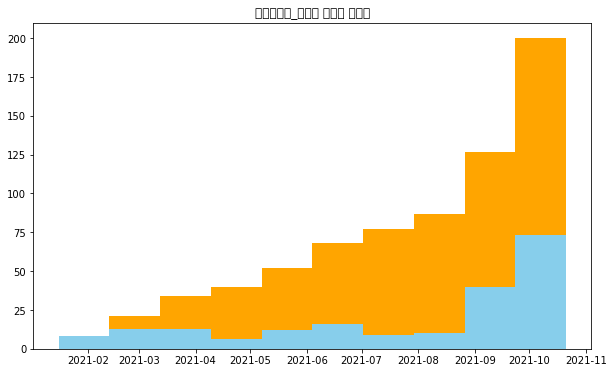

C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 53076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52852 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47700 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52740 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib

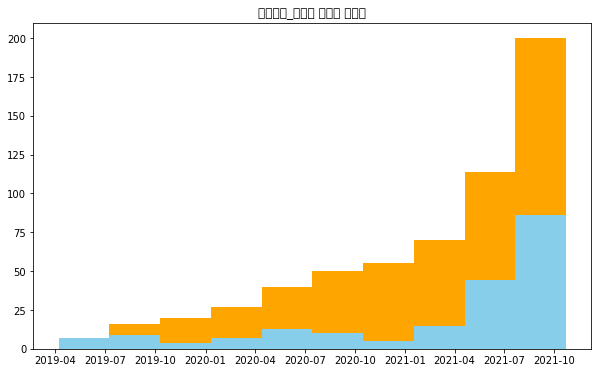

C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47805 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 53444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52280 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47805 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\heee\anaconda3\envs\bigdata\lib\site-packages\matplotlib\b

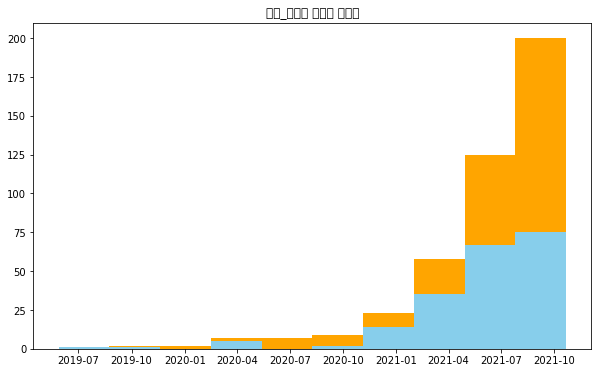

In [5]:
lists = ["하니칼국수_성시경", "코카모메_츄릅켠", "몽탄_전참시"]
for item in lists:
    file = "./data/naver_blog/rowdata/" + item + ".csv"
    temp = pd.read_csv(file)
    temp.sort_values(by = "postdate", ascending=True, inplace=True)
    temp.postdate = pd.to_datetime(temp['postdate'])
    # 기간 나누기
    # temp['period'] = temp['postdate'].dt.to_period(freq='M')  # 년-월
    # 그래프 그리기
    plt.figure(figsize=(10,6))
    temp["test"] = 1
    plt.hist(temp["postdate"], weights=temp["test"], bins=10, cumulative = True, color="orange")
    plt.hist(temp["postdate"], weights=temp["test"], bins=10, cumulative = False, color="skyblue")
    plt.title(item + " 시계열 그래프")
    plt.show()

In [ ]:
filelist = ["하니칼국수_성시경", "코카모메_츄릅켠", "몽탄_전참시"]
referenceDate = ['2021-05', '2021-08', "2021-03"]
for i in range(len(filelists)):
    file = "./data/naver_blog/rowdata/" + filelist[i] + ".csv"
    temp = pd.read_csv(file)
    temp.sort_values(by = "postdate", ascending=True, inplace=True)
    temp.postdate = pd.to_datetime(temp['postdate'])
    # 기간 나누기
    temp['period'] = temp['postdate'].dt.to_period(freq='M')  # 년-월
    # 기간별로 포스트 개수 세기
    period_count = temp.groupby("period").count()[["postdate"]]
    period_count.rename(columns = {"postdate": "count"}, inplace=True)
    # 누적합 열 추가하기
    period_count["cum"] = period_count[["count"]].cumsum()
    # 그래프 그리기
    plt.figure(figsize=(16,8))
    # 그래프를 그리기 위한 형변환
    period_count.index=period_count.index.to_series().astype(str)
    # 기준일 색깔 넣기
    my_color = np.where(period_count.index == referenceDate[0], 'skyblue', 'orange')
    # 라인그래프 그리기
    plt.plot(period_count.index, period_count["cum"], marker='o')
    # 기준일 그리기
    plt.axvline(referenceDate[i], color='lightgray', linestyle='--', linewidth=2)
    plt.text(referenceDate[i], period_count["cum"].max() * 0.95, "기준선",       
             fontsize = 15, 
             color='lightgray',
             horizontalalignment='center') 
    # 바그래프 그리기
    plt.bar(period_count.index, period_count["count"], color="blue",align='center')
    plt.title(filelists[i] + " 시계열 그래프")
    plt.savefig('./output/' + filelists[i] + ' 시계열 그래프.png')
    plt.show()

# 크롤링

In [ ]:
class NaverData:
    count = -1
    power = pd.DataFrame(columns = ["id","resource", "restaurant", "oldestDate", "reference_before", "referenceDate",
                                    "reference_after", "mostRecentDate", "blogTotal", "blogDisplay", "resource_count"])
    power.set_index(['id'], inplace=True)
    findData = pd.DataFrame(columns = ["id", "resource", "restaurant", "data"])
    findData.set_index(['id'], inplace=True)
    
    def __init__(self, resource, restaurant, display=200, referenceDate=None, data=None):
        self.resource = resource
        self.restaurant = restaurant
        if data is None:
            # 네이버 api로 데이터 가져오기
            naverData = NaverData.naverBlog(restaurant, display)
            self.lastBuildDate = naverData["lastBuildDate"]
            self.total = naverData["total"]
            self.display = display
            self.items = NaverData.cleanIteams(pd.DataFrame(naverData["items"]))
        else:
            # 로컬 저장소에 있는 데이터 가져오기
            tempData = data
            self.lastBuildDate = tempData["lastBuildDate"]
            self.total = tempData["total"]
            self.display = tempData["display"]
            self.items = tempData["items"]
        self.oldestDate = self.findOldestDate()
        self.mostRecentDate = self.findMostRecentDate()
        self.referenceData = self.findResource()
        self.referenceDate = referenceDate
        NaverData.count = NaverData.count + 1
        self.id = NaverData.count
        self.addPower()
        NaverData.findData.loc[self.id] = [resource, restaurant, self]
        print(resource, restaurant)
    
                                               
    def __del__(self):
        NaverData.power.drop(self.id, inplace=True)
        NaverData.findData.drop(self.id, inplace=True)
        print(self.id, "번 데이터를 지웁니다.")
    
    # 네이버 ReatAPI
    def naverBlog(query, num) :
        client_key = 'izGsqP2exeThwwEUVU3x'
        client_secret = 'WrwbQ1l6ZI'
        encText = urllib.parse.quote_plus(query)
        count = [[i,100] for i in range(1, num, 100)]
        if num % 100:
            count[-1][1] = num % 100 
        for i in count:
            naver_url = 'https://openapi.naver.com/v1/search/blog.json?query=' + encText + '&display=' + str(i[1]) +'&start=' + str(i[0])
            # request 객체에 add하기
            request = urllib.request.Request(naver_url)
            request.add_header("X-Naver-Client-Id",client_key)
            request.add_header("X-Naver-Client-Secret",client_secret)
            response = urllib.request.urlopen(request)
            # 응답받은 코드가 정상적인지 확인하기
            rescode = response.getcode()
            if(rescode == 200):
                response_body = response.read()
                if i[0] == 1:
                    dataList = json.loads(response_body)
                else:
                    dataList["items"] = dataList["items"] + json.loads(response_body)["items"]
            else:
                print('오류 코드 : ' + rescode)
        return dataList
    
    def cleanIteams(itemsdf):
        """
        items데이터프라임 -> items데이터프라임
         - items데이터프라임 title열과 description열에서 <b></b>&quot; 등 없얘기
         - items데이터프레임 postdate 타입을 datetime으로 변경하기
        """
        for i in range(itemsdf.shape[0]):
            # title열 데이터 정리하기
            title = re.sub("<b>|</b>", " ", str(itemsdf.loc[i,"title"]))
            title = re.sub("&.{1,5};", "", title)
            title = re.sub(" ( )+", "", title)
            itemsdf.loc[i,"title"] = title
            # description열 데이터 정리하기
            description = re.sub("<b>|</b>", " ", str(itemsdf.loc[i,"description"]))
            description = re.sub("&.{1,5};", "", description)
            description = re.sub(" ( )+", "", description)
            itemsdf.loc[i,"description"] = description
            # postdate열 타입을 datetime로 바꾸기
            itemsdf['postdate'] = pd.to_datetime(itemsdf['postdate'])
        return itemsdf
    
    def findResource(self):
        """
        items 데이터프레임 title열과 description열에서 resource단어가 들어간 데이터를 찾아 줍니다.
        """
        kkma = Kkma()
        mask = (self.items["title"] + self.items["description"]).map(kkma.nouns).map(lambda x: self.resource in x)
        return self.items.loc[mask]
    
    def findReferenceDate(self):
        """
        찾아온 데이터 중 블로그 제목과 설명에 제공자이름이 들어간 데이터 중 가장 오래된 데이터를 찾습니다.
        """
        if len(self.referenceData) <= 0:
            print("해당 게시물이 없습니다.")
            return pd.to_datetime('2099-12-31')  
        else:
            return self.referenceData.sort_values(by='postdate', ascending=True).iloc[0]["postdate"]
        
    def findOldestDate(self):
        """
        찾아온 데이터 중 가장 오래된 데이터를 찾습니다.
        """
        return self.items.sort_values(by='postdate', ascending=True).iloc[0]["postdate"]
    
    def findMostRecentDate(self):
        """
        찾아온 데이터 중 가장 최근 데이터를 찾습니다.
        """
        return self.items.sort_values(by='postdate', ascending=False).iloc[0]["postdate"]
    
    def countBF(self):
        """
        기준일을 기준으로 이전 게시물 갯수와 이후 게시물 갯수를 세줍니다.
        반환값 : {'before':X, 'after': X, 'resource_after':X}
        """
        # 기준일을 받지 않으면 게시물 중 가장 오래된 날짜로 지정한다.
        if self.referenceDate is None:
            self.referenceDate = self.findReferenceDate()
        before = len(self.items.loc[self.items['postdate'] < self.referenceDate])
        after = len(self.items.loc[self.items['postdate'] >= self.referenceDate])
        resource_after = len(self.referenceData.loc[self.referenceData['postdate'] >= self.referenceDate])
        return {'before':before, 'after': after, 'resource_after': resource_after}
    
    def addPower(self):
        bf = self.countBF()
        NaverData.power.loc[self.id] = [self.resource, self.restaurant, self.oldestDate, bf["before"], self.referenceDate,
                                        bf["after"], self.mostRecentDate, self.total, self.display, bf['resource_after']]

# (주의! 오래걸립니다..)로컬 저장소에 저장된 데이터 가져오기

In [ ]:
# rowdata 클래스로 만들기
temp = pd.read_csv("./data/naver_blog/total_power.csv")
for row in range(len(temp)):
    file = "./data/naver_blog/rowdata/" + temp.iloc[row]["restaurant"] + "_" + temp.iloc[row]["resource"] + ".csv"
    temp_items = pd.read_csv(file)
    data = {"lastBuildDate": None, "total": temp.iloc[row]["blogTotal"], "display" : len(temp_items),
           "items" : temp_items}
    try:
        NaverData(temp.iloc[row]["resource"], temp.iloc[row]["restaurant"], data=data)
    except:
        pass

In [ ]:
# 전체 정보 가져오기
naver_power = pd.read_csv("./data/naver_blog/total_power.csv")

# 음식점 데이터 가져오기

In [ ]:
df = pd.read_excel("./output/음식점 모음.xlsx", sheet_name="Sheet1")
resource_rastaurantDF = pd.DataFrame(columns = ["resource","rastaurant"])
# 데이터 변환하기
for col in df.columns:
    rastaurant = df[col].dropna()
    temp = pd.DataFrame({"rastaurant": rastaurant, "resource" : col})
    resource_rastaurantDF = resource_rastaurantDF.append(temp)
resource_rastaurantDF.reset_index(inplace=True)
resource_rastaurantDF.drop("index", axis=1, inplace=True)

# 네이버 파급력 측정하기

In [ ]:
# 만약 멈췄을때를 대비해서 미리미리 저장합니다
# 식당데이터를 20개씩 자르기
count = list(range(0, len(resource_rastaurantDF), 20)) + [len(resource_rastaurantDF)]
for i in range(len(count)-1):
    for row in range(count[i], count[i+1]):
        # 네이버 api로 데이터 요청하기
        tempNaverData = NaverData(resource_rastaurantDF.loc[row, "resource"], resource_rastaurantDF.loc[row, "rastaurant"])
        # 블로그 데이터 저장하기
        file = "./data/naver_blog/rowdata/" + NaverData.findData.loc[row, "restaurant"] + "_" + NaverData.findData.loc[row, "resource"] + ".csv"
        NaverData.findData.loc[row, "data"].items.to_csv(file, index=False)

# 확인하기

In [ ]:
display(NaverData.power)

# 저장하기

In [ ]:
# 파급력 저장하기
NaverData.power.to_csv("./data/naver_blog/total_power.csv", index=False)

In [ ]:
# 각각의 items데이터 저장하기
for row in range(len(NaverData.findData)):
    file = "./data/naver_blog/rowdata/" + NaverData.findData.loc[row, "restaurant"] + "_" + NaverData.findData.loc[row, "resource"] + ".csv"
    NaverData.findData.loc[row, "data"].items.to_csv(file, index=False)

In [ ]:
# 각각의 rowdata_resource 데이터 저장하기
for row in range(len(NaverData.findData)):
    file = "./data/naver_blog/rowdata_resource/" + NaverData.findData.loc[row, "restaurant"] + "_" + NaverData.findData.loc[row, "resource"] + ".csv"
    NaverData.findData.loc[row, "data"].referenceData.to_csv(file, index=False)

# 해볼 수 있는일

In [ ]:
# 클래스 메소들 만들기
mask = (NaverData.findData["resource"] == "김준현") & (NaverData.findData["restaurant"] == "원조수구레")
NaverData.findData.loc[mask].iloc[0]["data"].items

# 실험

In [ ]:
# html 빼기
text = "민락<동 얼큰칼국수&quot;<b>츄릅켠</b> 님 방송 보고 다녀옴!!!&quot;"
text = re.sub("<b>|</b>", " ", text)
text = re.sub("&.{1,5};", "", text)
print(text)

In [ ]:
sample = "해운대 원조할매국밥을 찾아가듯이 이 분위기와 쌈밥이 땡길때면 재방문할 의향이 있네요..."
kkma = Kkma() 
kkma.nouns(sample)
# pprint(kkma.morphs(sample))
# pprint(kkma.pos(sample))

In [ ]:
naverdata1 = NaverData("츄릅켠", "소문난원조쌈밥")
naverdata2 = NaverData("김준현", "원조수구레")

In [ ]:
plt.plot([10, 20, 30, 40], [1, 4, 9, 16], c="b",
         lw=5, ls="--", marker="o", ms=15, mec="g", mew=5, mfc="r")
plt.title("스타일 적용 예")
plt.show()

# 문제모음

1. 인스턴스가 삭제가 안됩니다.
2. 파일 데이터를 불러올때 몇몇의 파일을 읽어오지 못합니다.

In [ ]:
# 폰트설정2
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

# 폰트설정3
jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

# 폰트설정4
%matplotlib inline
import platform
path = './data/THEdog.ttf'
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unkonwn system... sorry~~~~')